In [362]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from config import *

## **Test/Positve dataset**

1. **Dataset before 2020-05-12**

* **extract dataset**

In [363]:
url_test1="https://www.data.gouv.fr/fr/datasets/r/b4ea7b4b-b7d1-4885-a099-71852291ff20"
dtype={'dep': str,'clage_covid':str,'nb_test':int,'nb_pos':int}
df_test1=pd.read_csv(url_test1,sep = ';',dtype=dtype)
df_test1.head()

,dep,jour,clage_covid,nb_test,nb_pos,nb_test_h,nb_pos_h,nb_test_f,nb_pos_f
0,01,2020-03-10,0,0,0,0,0,0,0
1,01,2020-03-10,A,0,0,0,0,0,0
2,01,2020-03-10,B,0,0,0,0,0,0
3,01,2020-03-10,C,0,0,0,0,0,0
4,01,2020-03-10,D,0,0,0,0,0,0


* **clean dataset**

In [364]:
#keep summary columns only (genre datas not used)
df_test1=df_test1.drop(["nb_test_h","nb_test_f","nb_pos_h","nb_pos_f"],axis=1)

In [365]:
#hospital dataset start on 2020-03-18 and second test/positive dataset start on 2020-05-12
df_test1=df_test1.drop(df_test1[(df_test1["jour"]<"2020-03-18") | (df_test1["jour"]>"2020-05-12")].index)
df_test1.head()

,dep,jour,clage_covid,nb_test,nb_pos
48,01,2020-03-18,0,37,8
49,01,2020-03-18,A,0,0
50,01,2020-03-18,B,15,1
51,01,2020-03-18,C,11,3
52,01,2020-03-18,D,4,3


In [366]:
#not interesting in age: keep only row where clage_covid=0 (summary row)
df_test1=df_test1.drop(df_test1[df_test1["clage_covid"] != "0"].index)
df_test1=df_test1.drop("clage_covid",axis=1)
df_test1.head()

,dep,jour,nb_test,nb_pos
48,01,2020-03-18,37,8
54,01,2020-03-19,82,13
60,01,2020-03-20,44,9
66,01,2020-03-21,13,1
72,01,2020-03-22,4,0


2. **Dataset after 2020-05-12**

* **import second dataset**

In [367]:
url_test2="https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
dtype={'dep': str,'P':int,'T':int,'cl_age':int}
df_test2=pd.read_csv(url_test2,sep = ';',dtype=dtype)
df_test2.head(14)

,dep,jour,P,T,cl_age90
0,01,2020-05-13,0,16,9
1,01,2020-05-13,1,16,19
2,01,2020-05-13,0,31,29
3,01,2020-05-13,1,71,39
4,01,2020-05-13,0,52,49
5,01,2020-05-13,0,40,59
6,01,2020-05-13,0,28,69
7,01,2020-05-13,1,29,79
8,01,2020-05-13,4,27,89
9,01,2020-05-13,2,13,90


* **clean dataset**

In [368]:
#rename colums and drop cl_age90 column
df_test2=df_test2.rename(columns={'P':'nb_pos','T':'nb_test'})
df_test2=df_test2.drop("cl_age90",axis=1)

In [369]:
#for each dep and date select the last row which is a sum of previous 
df_test2=df_test2.groupby(["dep","jour"]).tail(1)
df_test2.head()

,dep,jour,nb_pos,nb_test
10,01,2020-05-13,9,323
21,01,2020-05-14,9,427
32,01,2020-05-15,5,437
43,01,2020-05-16,0,142
54,01,2020-05-17,0,30


3. **Merge in one dataset**

In [370]:
df_test = pd.concat([df_test1,df_test2],ignore_index=True)
#create accumulation columns for nb_test and nb_pos
df_test['nb_test_cum']=df_test.groupby("dep")['nb_test'].cumsum()
df_test['nb_pos_cum']=df_test.groupby("dep")['nb_pos'].cumsum()
df_test.head()

,dep,jour,nb_test,nb_pos,nb_test_cum,nb_pos_cum
0,01,2020-03-18,37,8,37,8
1,01,2020-03-19,82,13,119,21
2,01,2020-03-20,44,9,163,30
3,01,2020-03-21,13,1,176,31
4,01,2020-03-22,4,0,180,31


## **Hospital dataset**

* **import dataset**

In [371]:
url2="https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
df_hospital = pd.read_csv(url2,sep=';')
df_hospital.head()

,dep,sexe,jour,hosp,rea,dc,rad
0,01,0,2020-03-18,2,0,0,1
1,01,1,2020-03-18,1,0,0,1
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,11,18
4,02,1,2020-03-18,19,4,6,11


* **clean dataset**

In [372]:
#Select only row where "sex"=0 (sum of "sex"=2 and "sex"=1 )
df_hospital = df_hospital.drop(df_hospital[df_hospital["sexe"]!=0 ].index).reset_index(drop=True)
df_hospital = df_hospital.drop(["sexe"],axis=1)
df_hospital.head()

,dep,jour,hosp,rea,dc,rad
0,01,2020-03-18,2,0,0,1
1,02,2020-03-18,41,10,11,18
2,03,2020-03-18,4,0,0,1
3,04,2020-03-18,3,1,0,2
4,05,2020-03-18,8,1,0,9


## **Create departement longitude/latitude Dataframe**

Source: <a href="https://www.ign.fr/sites/default/files/2020-09/Quels%20sont%20les%20centres%20des%2096%20d%C3%A9partements%20m%C3%A9tropolitains.pdf" target="_blank">https://www.ign.fr/sites/default/files/2020-09/Quels%20sont%20les%20centres%20des%2096%20d%C3%A9partements%20m%C3%A9tropolitains.pdf</a>

Source: <a href="https://www.coordonnees-gps.fr/" target="_blank">https://www.coordonnees-gps.fr/</a>

In [373]:
departements= df_test["dep"].unique()
print(departements)

['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '2A' '2B' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41'
 '42' '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55'
 '56' '57' '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69'
 '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83'
 '84' '85' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '971' '972'
 '973' '974' '976' '975' '977' '978']


In [374]:
#create zoom for scatter_mapbox
zoom_dep=[7.5]*len(departements)

In [375]:
#lat and long are the coordinates of the department center
data={'dep':departements,
      'dep_name':['Ain','Aisne','Allier','Alpes-de-Haute-Provence','Hautes-Alpes','Alpes_Maritimes','Ardeche','Ardennes','Ariege','Aube','Aude','Aveyron','Bouches-du-Rhône','Calvados','Cantal','Charente','Charente-Maritime','Cher','Correze',"Côte-d'Or","Côtes-D'Armor","Creuse","Dordogne","Doubs","Drome","Eure","Eure-et-Loire","Finistère","Corde-du-Sud","Haute-Corse","Gard","Haute-Garonne","Gers","Gironde","Hérault","Ille-et-Vilaine","Indre","Indre-et-Loire","Isère","Jura","Landes","Loir-et-Cher","Loire","Haute-Loire","Loire-Atlantique","Loiret","Lot","Lot-et-Garonne","Lozère","Manne-et-Loire","Manche","Marne","Haute-Marne","Mayenne","Meurthe-et-Moselle","Meuse","Morbihan","Moselle","Nièvre","Nord","Oise","Orne","Pas-de-Calais","Puy-de-Dôme","Pyrénées-Altantiques","Hautes-Pyrénées","Pyrénées-Orientales","Bas-Rhin","Haut-Rhin","Rhone","Haute-Saône","Saône-et-Loire","Sarthe","Savoie","Haute-Savoie","Paris","Seine-Maritime","Seine-et-Marne","Yvellines","Deux-Sèvres","Somme","Tarn","Tarn-et-Garonne","Var","Vaucluse","Vendée","Vienne","Haute-Vienne","Vosges","Yonne","Territoire de Belfort","Essonne","Hauts-de-Seine","Seine-Saint_Denis","Val-de-Marne","Val-d'Oise","Guadeloupe","Martinique","Guyane","La Réunion","Mayotte","Saint-Pierre-et-Miquelon","Saint-Barthélémy","Saint-Martin"],
      'lat':[46.1,49.55,44.1,44.09,44.66,43.94,44.73,49.61,42.94,48.31,43.10,44.28,43.54,49.10,45.01,45.71,45.76,47.07,45.34,47.43,48.44,46.08,45.13,47.16,44.68,49.10,48.39,48.27,41.88,42.37,43.99,43.35,43.68,44.84,43.90,48.18,46.80,47.24,45.27,46.73,43.96,47.61,45.72,45.13,47.38,47.85,44.63,44.37,44.51,47.39,49.08,48.38,48.09,48.12,48.79,49.00,47.85,49.02,47.10,50.45,49.39,48.61,50.49,45.73,43.28,43.05,42.61,48.65,47.86,45.86,47.63,46.64,48.00,45.47,46.04,48.85,49.65,48.60,48.97,46.53,49.97,43.77,44.07,43.47,43.99,46.67,46.55,45.87,48.19,47.84,47.62,48.52,48.83,48.90,48.77,49.07,16.00,14.60,4.93,-20.88,-12.77,46.78,17.90,18.06],
      'long':[5.33,3.56,2.35,6.23,6.21,7.12,4.41,4.61,1.53,4.14,2.35,2.72,5.03,-0.37,2.66,0.20,-0.71,2.52,1.81,4.78,-2.85,2.04,0.70,6.37,5.15,1.00,1.36,-4.04,8.97,9.23,4.17,1.23,0.45,-0.58,4.47,-1.64,1.62,0.69,5.61,5.69,-0.80,1.41,4.16,3.81,-1.71,2.26,1.59,0.46,3.49,-0.53,-1.34,7.47,5.15,-0.67,6.16,5.39,-2.83,6.65,3.51,3.20,2.42,0.11,2.27,3.14,-0.75,0.16,2.51,7.56,7.27,4.66,6.07,4.53,0.19,6.45,6.44,2.35,1.04,2.97,1.97,-0.32,2.29,2.18,1.28,6.18,5.14,-1.28,0.50,1.23,6.37,3.57,6.92,2.26,2.24,2.48,2.45,2.17,-61.73,-61.06,-52.32,55.45,45.22,-56.19,-62.81,-63.08],
      'zoom':zoom_dep
     }

* **Create departments info dataframe**

In [376]:
df_coord = pd.DataFrame(data,columns=['dep','dep_name','lat','long','zoom'])
df_coord.head()

,dep,dep_name,lat,long,zoom
0,01,Ain,46.10,5.33,7.5
1,02,Aisne,49.55,3.56,7.5
2,03,Allier,44.10,2.35,7.5
3,04,Alpes-de-Haute-Provence,44.09,6.23,7.5
4,05,Hautes-Alpes,44.66,6.21,7.5


## **Complete Dataset**

* **merge all datasets**

In [377]:
df_dep = pd.merge(df_hospital,df_test,on=['dep','jour'])
df_dep = pd.merge(df_dep,df_coord,on=['dep'])

In [378]:
#sort by departements and date
df_dep=df_dep.sort_values(['dep','jour'])
df_dep.head()

,dep,jour,hosp,rea,dc,rad,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom
0,01,2020-03-18,2,0,0,1,37,8,37,8,Ain,46.1,5.33,7.5
1,01,2020-03-19,2,0,0,1,82,13,119,21,Ain,46.1,5.33,7.5
2,01,2020-03-20,2,0,0,1,44,9,163,30,Ain,46.1,5.33,7.5
3,01,2020-03-21,4,0,0,1,13,1,176,31,Ain,46.1,5.33,7.5
4,01,2020-03-22,8,1,0,2,4,0,180,31,Ain,46.1,5.33,7.5


* **create new columns**

In [379]:
#scale for scatter mapbox
df_dep["scaled"] = df_dep["nb_pos_cum"] ** 0.77

In [380]:
#create death rate and new death rate columns
df_dep['death_rate']=round(df_dep['dc']/df_dep['nb_pos_cum']*100,2)
df_dep["new_death_rate"]=df_dep.groupby("dep")["death_rate"].apply(lambda row: round(row-(row.shift(1)),2))
df_dep["new_death_rate"].fillna(df_dep["death_rate"], inplace = True) # first date, new_death_rate = death rate
df_dep.head()

,dep,jour,hosp,rea,dc,rad,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom,scaled,death_rate,new_death_rate
0,01,2020-03-18,2,0,0,1,37,8,37,8,Ain,46.1,5.33,7.5,4.958831,0.0,0.0
1,01,2020-03-19,2,0,0,1,82,13,119,21,Ain,46.1,5.33,7.5,10.425787,0.0,0.0
2,01,2020-03-20,2,0,0,1,44,9,163,30,Ain,46.1,5.33,7.5,13.720924,0.0,0.0
3,01,2020-03-21,4,0,0,1,13,1,176,31,Ain,46.1,5.33,7.5,14.071763,0.0,0.0
4,01,2020-03-22,8,1,0,2,4,0,180,31,Ain,46.1,5.33,7.5,14.071763,0.0,0.0


In [381]:
#create new deaths by day
df_dep["new_dc"]=df_dep.groupby("dep")["dc"].apply(lambda row: row-(row.shift(1)))
df_dep["new_dc"].fillna(df_dep["dc"], inplace = True) # first date, new_dc = dc
df_dep.head()

,dep,jour,hosp,rea,dc,rad,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom,scaled,death_rate,new_death_rate,new_dc
0,01,2020-03-18,2,0,0,1,37,8,37,8,Ain,46.1,5.33,7.5,4.958831,0.0,0.0,0.0
1,01,2020-03-19,2,0,0,1,82,13,119,21,Ain,46.1,5.33,7.5,10.425787,0.0,0.0,0.0
2,01,2020-03-20,2,0,0,1,44,9,163,30,Ain,46.1,5.33,7.5,13.720924,0.0,0.0,0.0
3,01,2020-03-21,4,0,0,1,13,1,176,31,Ain,46.1,5.33,7.5,14.071763,0.0,0.0,0.0
4,01,2020-03-22,8,1,0,2,4,0,180,31,Ain,46.1,5.33,7.5,14.071763,0.0,0.0,0.0


* **select last day for each department**

In [382]:
df_last_update=df_dep.groupby("dep").tail(1).reset_index(drop=True)
df_last_update.head()

,dep,jour,hosp,rea,dc,rad,nb_test,nb_pos,nb_test_cum,nb_pos_cum,dep_name,lat,long,zoom,scaled,death_rate,new_death_rate,new_dc
0,01,2020-11-12,442,35,199,880,2600,556,175734,26529,Ain,46.10,5.33,7.5,2548.385219,0.75,0.00,5.0
1,02,2020-11-12,238,31,345,1434,1701,223,105020,9324,Aisne,49.55,3.56,7.5,1139.183652,3.70,-0.08,1.0
2,03,2020-11-12,249,25,124,521,1381,282,80547,7170,Allier,44.10,2.35,7.5,930.571505,1.73,-0.04,2.0
3,04,2020-11-12,121,13,35,263,358,42,41987,3355,Alpes-de-Haute-Provence,44.09,6.23,7.5,518.541171,1.04,0.01,1.0
4,05,2020-11-12,174,21,51,297,360,69,31012,4396,Hautes-Alpes,44.66,6.21,7.5,638.490466,1.16,0.00,1.0


In [383]:
#some tests
n=df_last_update.loc[df_last_update["dep_name"]=="Aisne"]
print(n.iloc[0]["new_death_rate"])

-0.08


## **France dataset**

In [384]:
df_france=df_dep.groupby("jour").sum().reset_index()
df_france['death_rate']=round(df_france['dc']/df_france['nb_pos_cum']*100,2)
df_france['new_death_rate']=round(df_france.death_rate-df_france.death_rate.shift(1),2)
df_france["new_death_rate"].fillna(df_france["death_rate"], inplace = True) # first date, new_death_rate = death rate
df_france["lat"]=46.40
df_france["long"]=0.5
df_france["zoom"]=3.5

## **Plot Figures**

### **Map**

In [385]:
color_scale = ["#fadc8f",
        "#f9d67a",
        "#f8d066",
        "#f8c952",
        "#f7c33d",
        "#f6bd29",
        "#f5b614",
        "#F4B000",
        "#eaa900",
        "#e0a200",
        "#dc9e00",]



In [386]:
px.set_mapbox_access_token(MAPBOX_ACCESS_TOKEN)

In [387]:
def plot_map(lat=46.4,lon=0.5,zoom=3.5):    
    fig = px.scatter_mapbox(
        df_last_update,
        lat = "lat",
        lon = "long",
        color = "nb_pos_cum",
        size="scaled",
        size_max = 35,
        hover_name = "dep_name",
        hover_data = ["nb_pos_cum","dc","death_rate","dep_name"],
        color_continuous_scale = color_scale,
    )

    fig.layout.update(
            mapbox_style="dark",
            mapbox=dict(center=dict(lat=lat, lon=lon), zoom=zoom),
        )
    fig.data[0].update(
            hovertemplate=("%{customdata[3]}<br>Confirmed:"
                          " %{customdata[0]}<br>Deaths: %{customdata[1]}<br>Death Rate: %{customdata[2]}")
        )

    fig.show()

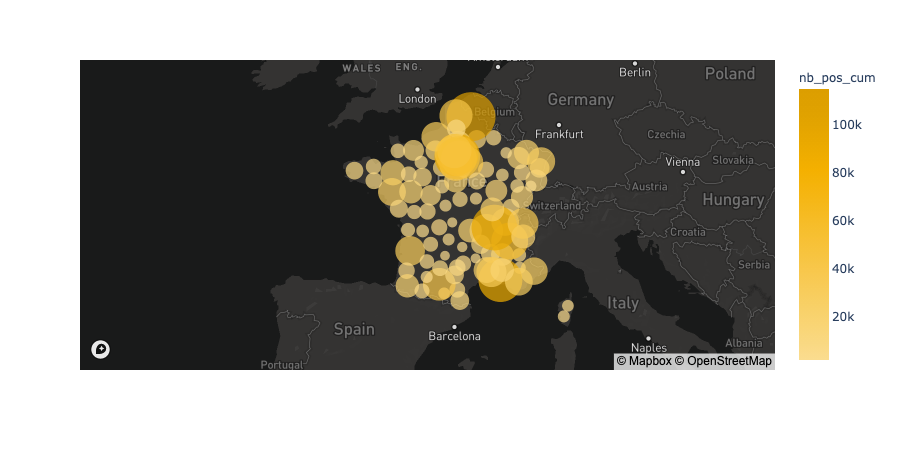

In [388]:
plot_map()

### **Graph**

In [389]:
#parameters for graph
last_days=30 #number of last days to plot
select_df="country" #select dataframe to use
dep_name = "Aisne" #if department dataframe used, department to focus

In [390]:
#dictionnary of differents dataframes
all_df={"departments":df_dep[df_dep["dep_name"]==dep_name],"country":df_france}

1. **Confirmed Cases**

In [391]:
def confirmed_cases(selected_df,last_days_nb):    
    yaxis_max=np.log10(selected_df['nb_pos_cum'].tail(1).tolist()[0])+0.5 
    fig_confirmed = go.Figure()
    fig_confirmed.add_trace(
        go.Scatter(
            x=selected_df['jour'].tail(last_days_nb),
            y=selected_df['nb_pos_cum'].tail(last_days_nb),
            mode="lines",
            line={"color":"#dc9e00"},
            showlegend=False,
            #name="Total Confirmed Cases"
        )
    )
    fig_confirmed.add_trace(
        go.Bar(
            x=selected_df['jour'].tail(last_days),
            y=selected_df['nb_pos'].tail(last_days),
            marker={"color":"#f9d67a"},
            showlegend=False,
            #name="New Confirmed Cases",

        )
    )


    # LINE CHART ANNOTATION
    fig_confirmed.add_annotation(
         x=selected_df['jour'].tail(1).tolist()[0],
         y=yaxis_max,
         text="Total Confirmed Cases",
         font={"size": 14,"color":"#dc9e00"},
         xshift=-220,  # Annotation x displacement!
         showarrow=False,
    )

    # BAR CHART ANNOTATION
    fig_confirmed.add_annotation(
        x=selected_df['jour'].tail(last_days).tolist()[0],
        y=np.log10(selected_df['nb_pos'].tail(last_days).max()),
        text="New Confirmed Cases",
        font={"size": 14, "color":"#f9d67a"},
        xshift=100,  # Annotation x displacement!
        yshift=20,  # Annotation y displacement!
        showarrow=False,
        )
    fig_confirmed.update_layout(
        template="plotly_dark",
        xaxis={"title":"Dates"},
        yaxis=dict(range=[0,yaxis_max],title="Number of cases"),
        yaxis_type="log",
        autosize=True,
    )
    fig_confirmed.show()

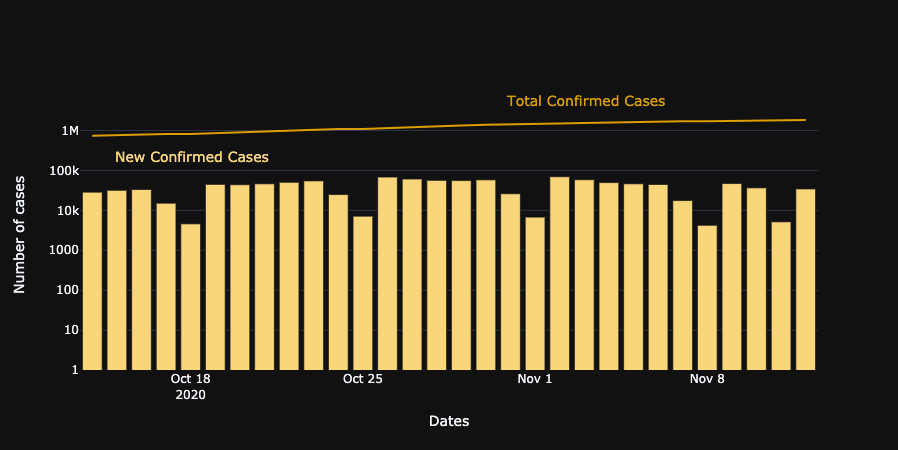

In [392]:
confirmed_cases(all_df[select_df],last_days)

2. **Covid19 Deaths**

In [393]:
def covid_deaths(selected_df,last_days_nb):    
    yaxis_max=np.log10(selected_df['dc'].tail(1).tolist()[0])+0.5
    fig_confirmed = go.Figure()
    fig_confirmed.add_trace(
        go.Scatter(
            x=selected_df['jour'].tail(last_days_nb),
            y=selected_df['dc'].tail(last_days_nb),
            mode="lines",
            line={"color":"#C616C4"},
            showlegend=False,
            #name="Total Confirmed Cases"
        )
    )
    fig_confirmed.add_trace(
        go.Bar(
            x=selected_df['jour'].tail(last_days_nb),
            y=selected_df['new_dc'].tail(last_days_nb),
            marker={"color":"#e66ee0"},
            showlegend=False,
            #name="New Confirmed Cases",

        )
    )


    # LINE CHART ANNOTATION
    fig_confirmed.add_annotation(
         x=selected_df['jour'].tail(1).tolist()[0],
         y=yaxis_max,
         text="Total Deaths",
         font={"size": 14,"color":"#C616C4"},
         xshift=-220,  # Annotation x displacement!
         showarrow=False,
    )

    # BAR CHART ANNOTATION
    fig_confirmed.add_annotation(
        x=selected_df['jour'].tail(1).tolist()[0],
        y=np.log10(selected_df['new_dc'].tail(last_days_nb).max()),
        text="New Deaths",
        font={"size": 14, "color":"#e66ee0"},
        xshift=-60,  # Annotation x displacement!
        yshift=20,  # Annotation y displacement!
        showarrow=False,
        )
    fig_confirmed.update_layout(
        template="plotly_dark",
        xaxis={"title":"Dates"},
        yaxis=dict(range=[0,yaxis_max],title="Number of deaths"),
        yaxis_type="log",
        autosize=True,
        
    )
    fig_confirmed.show()

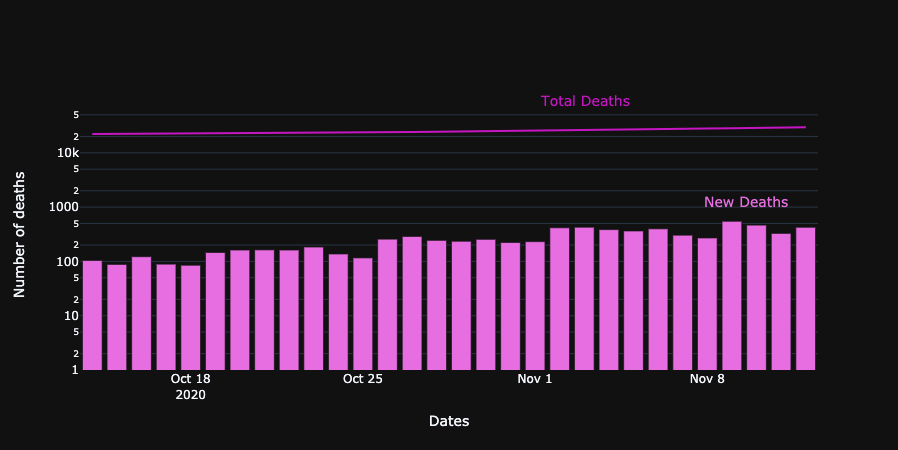

In [394]:
covid_deaths(all_df[select_df],last_days)